In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vanessa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
path = "./data/EA_tweets.xlsx"
spreadsheet = "Stream"
tweets = pd.read_excel(path, sheet_name=spreadsheet)

tweets.head()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,...,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs
0,743021277988958208,2016-06-15,10:04,bored2tears,bored2tears,"Trader interested in breaking stocks, CRE, eco...","#VR hardware is here, but robust game lineup i...",1.0,NaN,47.50012,...,923.0,en,http://www.twitter.com/bored2tears/status/7430...,False,NaN,NaN,"#VR,#E3,#tech","$EA,$MSFT,$SNE",http://pbs.twimg.com/media/Ck-96cBXIAAkT4I.jpg,http://twitthat.com/2u1G2
1,743000607397679104,2016-06-15,08:42,Ken Edwards,kenedwards_ken,NaN,OVAS Pacific Biosciences of California Inc. Ex...,NaN,NaN,NaN,...,32.0,en,http://www.twitter.com/kenedwards_ken/status/7...,False,NaN,NaN,"#invest,#stock","$OVAS,$QRVO,$EA,$TMF",NaN,http://dlvr.it/LZ2VxG
2,742994939777286144,2016-06-15,08:19,Abu Sofyan Pabitjara,APabitjara,NaN,"$EA Rf xcw€•£*cc. Ze,*$*3,r#43€•¢t,😠°==™©•√",NaN,NaN,NaN,...,NaN,es,http://www.twitter.com/APabitjara/status/74299...,False,NaN,NaN,NaN,$EA,NaN,NaN
3,742992053852852224,2016-06-15,08:08,JennaKingtin1978,kingtin1978,NaN,FXA CurrencyShares British Pound Sterling Trus...,NaN,NaN,NaN,...,37.0,en,http://www.twitter.com/kingtin1978/status/7429...,False,NaN,NaN,"#nasdaq,#investing","$FXA,$IVOB,$EA,$HTS",NaN,http://dlvr.it/LZ1qTL
4,742985503641894913,2016-06-15,07:42,ezzmoney2day,ezzmoney2day,NaN,CBT Cabot Corp. Yield\nhttps://t.co/0kL5KBx2QD...,NaN,NaN,NaN,...,38.0,en,http://www.twitter.com/ezzmoney2day/status/742...,False,NaN,NaN,"#stockmarket,#nasdaq","$CBT,$EA,$SQQQ,$HXU.TO",NaN,http://dlvr.it/LZ1NHQ


In [3]:
tweets.dtypes

Tweet Id                        int64
Date                           object
Hour                           object
User Name                      object
Nickname                       object
Bio                            object
Tweet content                  object
Favs                          float64
RTs                           float64
Latitude                      float64
Longitude                     float64
Country                        object
Place (as appears on Bio)      object
Profile picture                object
Followers                     float64
Following                     float64
Listed                        float64
Tweet language (ISO 639-1)     object
Tweet Url                      object
Is a RT                          bool
Original Tweet User Name       object
User Mentions                  object
Hashtags                       object
Symbols                        object
Media                          object
URLs                           object
dtype: objec

In [4]:
tweets["Date"] = pd.to_datetime(tweets["Date"], format="%Y-%m-%d")

In [18]:
print(min(tweets.Date))
print(max(tweets.Date))

2016-03-27 00:00:00
2016-06-15 00:00:00


In [5]:
tweets['Tweet language (ISO 639-1)'].unique()

array(['en', 'es', 'de', 'fi', 'nl', 'pt', 'da', 'fr', 'sv', 'it', 'ru'],
      dtype=object)

In [6]:
tweets['Tweet language (ISO 639-1)'].nunique()

11

<AxesSubplot:title={'center':'Number of Tweets per Language'}, xlabel='Language', ylabel='Number of Tweets'>

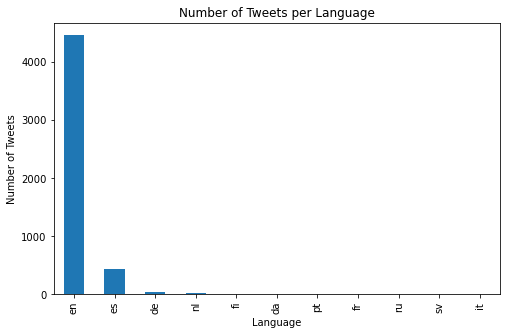

In [7]:
tweets_per_language = pd.Series(tweets['Tweet language (ISO 639-1)'].value_counts())

tweets_per_language.plot(kind='bar', 
                         figsize=(8,5), 
                         title="Number of Tweets per Language",
                         xlabel="Language",
                         ylabel="Number of Tweets",
                        )

In [8]:
tweets_per_language

en    4450
es     440
de      48
nl      16
fi      12
da       8
pt       6
fr       6
ru       6
sv       2
it       1
Name: Tweet language (ISO 639-1), dtype: int64

Twitter language is messy. The dataset contains 11 unique languages. Getting rid of URLs and user names because they don't add anything to the context of the text. Usernames usually follow an "@" symbol and retweets have an "RT" tag before the twitter handle. URLs are usually shortened code that redirect to another twitter page. I will be keeping the tickers and hashtags as they can contain information about the tweet. Preprocessing could be difficult because some tweets use symbols to replace a letter in a word (eg. J@ck, \\$ea$on).

[Regex cheatsheet](https://quickref.me/regex)

In [9]:
def text_preprocess(content):
    """
    Cleans the content of Tweets by removing URLs, user handles, and retweets
    """
    tweets["cleaned_tweets"] = tweets["Tweet content"].replace(r"https?://[a-zA-Z0-9./]*", "", regex=True)
    tweets["cleaned_tweets"] = tweets["cleaned_tweets"].replace(r"\s?RT\s*@[a-zA-z0-9]*:\s", "", regex=True)
    tweets["cleaned_tweets"] = tweets["cleaned_tweets"].replace(r"(\s|^|\W)@[\w]*\)?", "", regex=True)
    tweets["cleaned_tweets"] = tweets["cleaned_tweets"].replace(r"^\s\-\s", "", regex=True)
    tweets["cleaned_tweets"] = tweets["cleaned_tweets"].replace(r"\s+", " ", regex=True)
#     tweets["cleaned_tweets"] = tweets["cleaned_tweets"].replace(r"([0-9]),([0-9])", r"\1\2", regex=True)
    tweets["cleaned_tweets"] = tweets["cleaned_tweets"].str.strip()
    
# for tweet in tweets["cleaned"].values:
#     print(tweet)
#     print()

In [10]:
text_preprocess(tweets["Tweet content"])

In [11]:
cleaned_text = tweets[["Date", "Hour", "cleaned_tweets", "RTs", "Followers", "Tweet language (ISO 639-1)"]]

cleaned_text.tail()

,Date,Hour,cleaned_tweets,RTs,Followers,Tweet language (ISO 639-1)
4990,2016-03-28,00:26,$EA there's a reason it's stalling right here....,NaN,1755.0,en
4991,2016-03-27,22:38,Ave. $ea$on prod ICDMAW,4.0,489.0,es
4992,2016-03-27,22:33,Ave. $ea$on prod ICDMAW,4.0,1024.0,es
4993,2016-03-27,22:26,$EA:US Oculus' Virtual Reality Headset To Laun...,NaN,2746.0,en
4994,2016-03-27,22:05,$EA: Electronic Arts (EA) Short Interest Discl...,NaN,737.0,en


In [12]:
cleaned_text.to_csv("./data/EA_tweets_cleaned.csv", index=False)

**Getting sentiment for each tweet**

In [19]:
# empty text fields?
# tweets[(tweets["cleaned_tweets"].isnull())]
tweets[(tweets["cleaned_tweets"]=="")]

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,...,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs,cleaned_tweets


VADER uses a scoring method that gives a score on how negative, positive, or neutral a statement is. Scoring is scaled between -1 as the most negative and +1 as most positive. Compound score is the normalized score of all the sentiments.

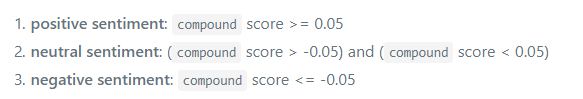

In [119]:
# tweets["cleaned_tweets"][tweets['Tweet language (ISO 639-1)']=="es"].values

- https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
- https://python.plainenglish.io/twitter-sentiment-analysis-using-vader-tweepy-b2a62fba151e

In [20]:
# TODO: function
vader_score = SentimentIntensityAnalyzer()

# def vader_sentiment():
scores = []

# Declare variables for scores
# compound_list = []
# positive_list = []
# negative_list = []
# neutral_list = []

for i in range(tweets["cleaned_tweets"].shape[0]):
    #print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = vader_score.polarity_scores(tweets["cleaned_tweets"][i])["compound"]
    pos = vader_score.polarity_scores(tweets["cleaned_tweets"][i])["pos"]
    neu = vader_score.polarity_scores(tweets["cleaned_tweets"][i])["neu"]
    neg = vader_score.polarity_scores(tweets["cleaned_tweets"][i])["neg"]
    
    scores.append({"Compound": compound,
                   "Positive": pos,
                   "Negative": neg,
                   "Neutral": neu
                  })

In [21]:
sentiments_score = pd.DataFrame.from_dict(scores)
cleaned_text = cleaned_text.join(sentiments_score)

cleaned_text.head()

,Date,Hour,cleaned_tweets,RTs,Followers,Tweet language (ISO 639-1),Compound,Positive,Negative,Neutral
0,2016-06-15,10:04,"#VR hardware is here, but robust game lineup i...",NaN,5172.0,en,0.4767,0.193,0.0,0.807
1,2016-06-15,08:42,OVAS Pacific Biosciences of California Inc. Ex...,NaN,71.0,en,0.0000,0.000,0.0,1.000
2,2016-06-15,08:19,"$EA Rf xcw€•£*cc. Ze,*$*3,r#43€•¢t,😠°==™©•√",NaN,6.0,es,0.0000,0.000,0.0,1.000
3,2016-06-15,08:08,FXA CurrencyShares British Pound Sterling Trus...,NaN,86.0,en,0.5106,0.216,0.0,0.784
4,2016-06-15,07:42,CBT Cabot Corp. Yield $CBT $EA $SQQQ $HXU.TO #...,NaN,58.0,en,0.0000,0.000,0.0,1.000


In [23]:
cleaned_text.to_csv("./data/tweets_sentiment.csv", index=False)